In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
import os

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

## Data

In [11]:
disease_types=['Covid-19', 'Pneumonia','normal']
data_dir = '/content/drive/MyDrive/X-RayImageDataSet/train'
train_dir = os.path.join(data_dir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,Covid-19/nejmoa2001191_f4.jpeg,0,Covid-19
1,Covid-19/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87....,0,Covid-19
2,Covid-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg,0,Covid-19
3,Covid-19/covid-19-rapidly-progressive-acute-re...,0,Covid-19
4,Covid-19/figure1-5e71be566aa8714a04de3386-98-l...,0,Covid-19


## Randomize the order of training set

In [13]:

SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Pneumonia/00002633_016.png,1,Pneumonia
1,normal/00003847_012.png,2,normal
2,Pneumonia/00004344_035.png,1,Pneumonia
3,Pneumonia/Copy of 00006605_008.png,1,Pneumonia
4,normal/00001689_008.png,2,normal


## HISTOGRAM

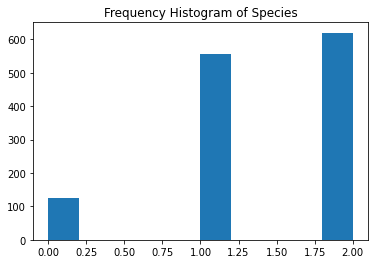

<Figure size 864x864 with 0 Axes>

In [14]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

## Classification of X-ray

In [49]:
np.random.seed(41)
data = ImageDataBunch.from_folder('/content/drive/MyDrive/X-RayImageDataSet/', train="train",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to 

In [50]:
data.classes

['Covid-19', 'Pneumonia', 'normal']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

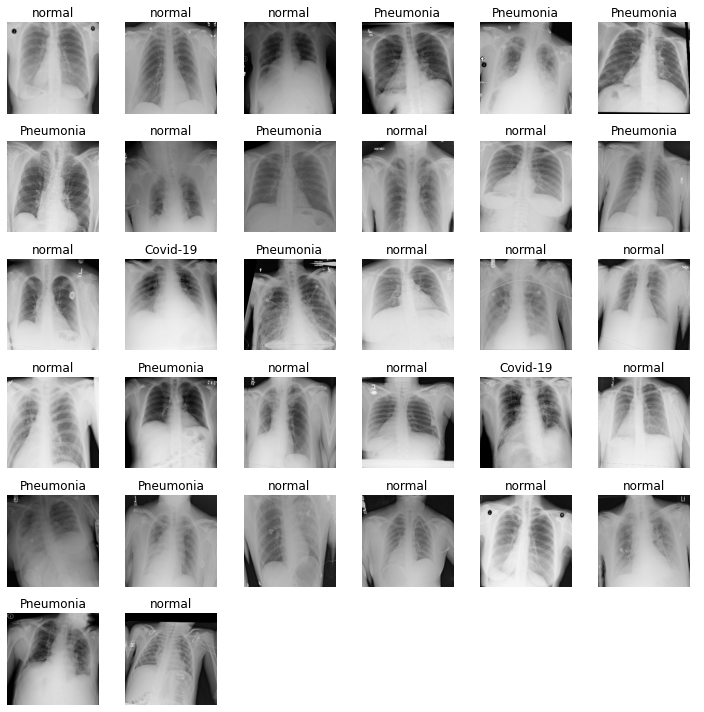

In [51]:
data.show_batch(rows=20, figsize=(10,10))

## Image Read and Resize Function

In [16]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [17]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

1300it [08:58,  2.42it/s]

Train Shape: (1300, 64, 64, 3)


## Converting Labels to Categorical

In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)

## Splitting the Train and Test

In [20]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

##Training Set images

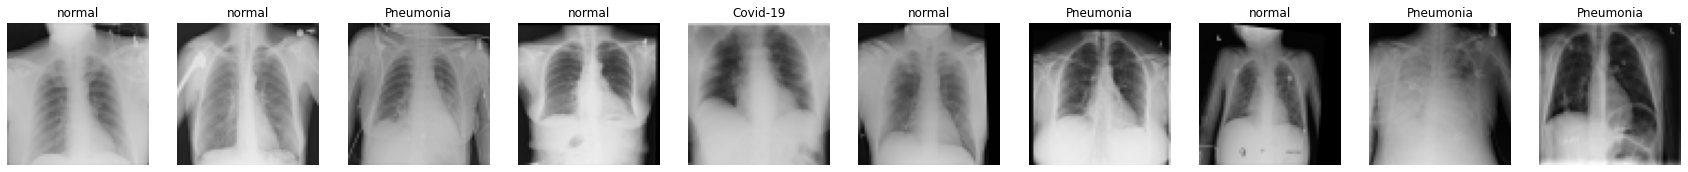

In [64]:
fig, ax = plt.subplots(1, 10, figsize=(30, 30))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

##Validation Set images

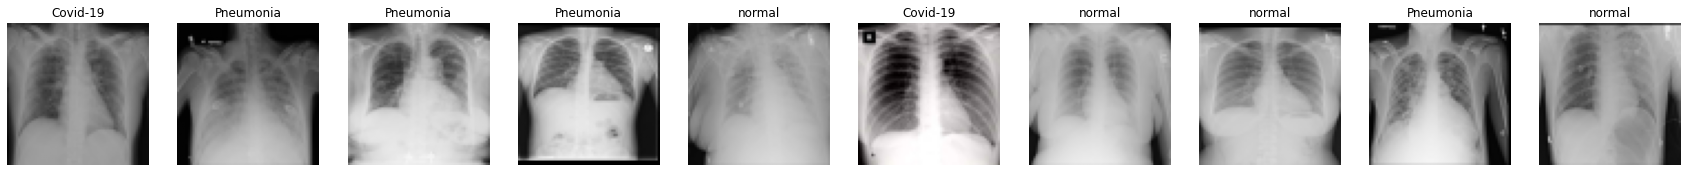

In [65]:
fig, ax = plt.subplots(1, 10, figsize=(30, 30))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_val[i])
    ax[i].set_title(disease_types[np.argmax(Y_val[i])])

In [25]:
EPOCHS = 50
SIZE=64
N_ch=3

## DenseNet121 Model

In [29]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

## Data Augmentation and Fitting Model 

In [30]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=False) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 - 62s - loss: 2.0100 - accuracy: 0.3350 - val_loss: 1.4774 - val_accuracy: 0.3846

Epoch 00001: val_loss improved from inf to 1.47742, saving model to model.h5
Epoch 2/50
16/16 - 51s - loss: 1.7657 - accuracy: 0.3934 - val_loss: 1.3429 - val_accuracy: 0.4231

Epoch 00002: val_loss improved from 1.47742 to 1.34288, saving model to model.h5
Epoch 3/50
16/16 - 53s - loss: 1.6445 - accuracy: 0.4023 - val_loss: 1.2772 - val_accuracy: 0.4192

Epoch 00003: val_loss improved from 1.34288 to 1.27719, saving model to model.h5
Epoch 4/50
16/16 - 52s - loss: 1.5364 - accuracy: 0.4668 - val_loss: 1.2239 - val_accuracy: 0.4115

Epoch 00004: val_loss improved from 1.27719 to 1.22390, saving model to model.h5
Epoch 5/50
16/16 - 50s - loss: 1.3648 - accuracy: 0.5041 - val_loss: 1.2708 - val_accuracy: 0.4308

Epoch 00005: val_loss did not improve from 1.22390
Epoch 6/50
16/16 - 50s - loss: 1.3970 - accuracy: 0.4980 - val_loss: 1.1435 - val_accuracy: 0.4269

Epoch 00006: val_loss improved from 1.22

## Final Loss and Accuracy

In [31]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

9/9 [==============================] - 2s 250ms/step - loss: 0.4380 - accuracy: 0.8308
Final Loss: 0.4379623234272003, Final Accuracy: 0.8307692408561707


## Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

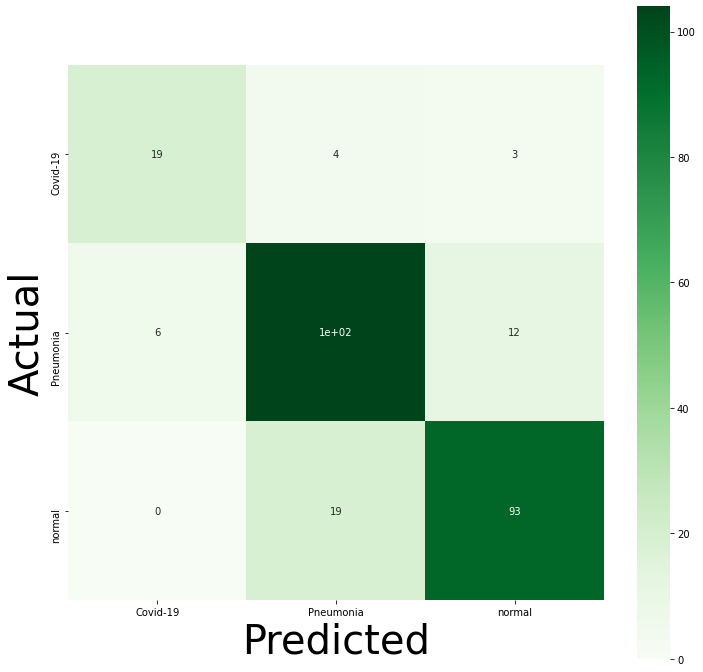

In [32]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Accuracy and Loss Curve

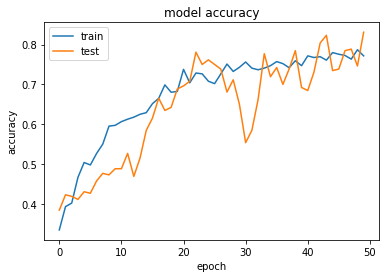

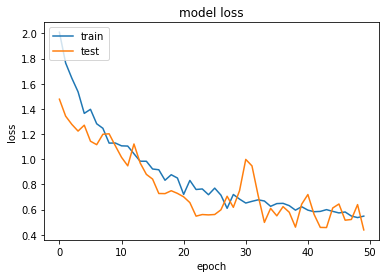

In [33]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

[0.03267802 0.9602672  0.00705481]


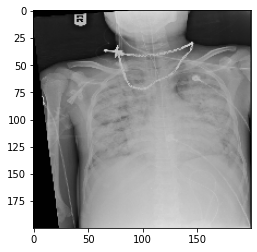

Prediction: Pneumonia


In [38]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/X-RayImageDataSet/train/Pneumonia/00001255_031.png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/X-RayImageDataSet/train/Pneumonia/00001255_031.png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Pneumonia','normal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [41]:
dense_model = DenseNet121(weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
dense_model.save('model_1.h5')

33193984/33188688 [==============================] - 0s 0us/step
